In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [22]:
class MovingAverageRSIStrategy:
    
    def __init__(self, capital, stock, start, end, short_period, long_period):
        self.data = None
        self.is_long = False
        self.short_period = short_period
        self.long_period  = long_period
        self.capital = capital
        self.equity = [capital]
        self.stock = stock
        self.start = start
        self.end = end
        
    def download_data(self):
        stock_data = {}
        ticker = yf.download(self.stock, self.start, self.end)
        stock_data['price'] = ticker['Adj Close']
        self.data = pd.DataFrame(stock_data)
        
    def construct_signals(self):
        self.data['short_ma'] = self.data['price'].ewm(span=self.short_period).mean()
        self.data['long_ma'] = self.data['price'].ewm(span=self.long_period).mean()
        self.data['move'] = self.data['price'] - self.data['price'].shift(1) 
        self.data['up'] = np.where(self.data['move'] > 0, self.data['move'], 0)
        self.data['down'] = np.where(self.data['move'] < 0, self.data['move'], 0)
        
        self.data['average_gain'] = self.data['up'].rolling(14).mean()
        self.data['average_loss'] = self.data['down'].abs().rolling(14).mean()
        relative_strength = self.data['average_gain'] / self.data['average_loss']
        self.data['rsi'] = 100.0 - (100.0 / (1.0 + relative_strength))
        self.data = self.data.dropna()
        print(self.data)
        
    def plot_signals(self):
        plt.figure(figsize=(12,6))
        plt.plot(self.data.price, label='Stock Price')
        plt.plot(self.data.short_ma, label='Short MA', color='blue')
        plt.plot(self.data.long_ma, label='Long MA', color='green')
        plt.title('Moving Average (MA) Crossover Trading Strategy with RSI')    
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.show()
        
    def simulate(self):
        price_when_buy = 0
        
        for index, row in self.data.iterrows():
            if row['short_ma'] < row['long_ma'] and self.is_long:
                self.equity.append(row['price'] * self.capital / price_when_buy)
                self.is_long = False

            elif row['short_ma'] > row['long_ma'] and not self.is_long \
                    and row['rsi'] < 30:
                price_when_buy = row['price']
                self.is_long = True
                                
    def plot_equity(self):
        print("Profit of the trading strategy: %.2f%%" % (
                (float(self.equity[-1] - float(self.equity[0]))) /
                float(self.equity[0]) * 100))
        print("Actual capital: $%0.2f" % self.equity[-1])
        plt.figure(figsize=(12, 6))
        plt.title('Equity Curve')
        plt.plot(self.equity, label='Stock Price', color='green')
        plt.xlabel('Date')
        plt.ylabel('Actual Capital ($)')
        plt.show()        

[*********************100%***********************]  1 of 1 completed
                 price    short_ma     long_ma      move        up      down  \
Date                                                                           
2010-01-22   86.704697   90.067314   90.132670 -2.418060  0.000000 -2.418060   
2010-01-25   87.133049   89.796075   89.913496  0.428352  0.428352  0.000000   
2010-01-26   86.877396   89.537563   89.704178 -0.255653  0.000000 -0.255653   
2010-01-27   87.278122   89.345099   89.545743  0.400726  0.400726  0.000000   
2010-01-28   85.495674   89.028713   89.294339 -1.782448  0.000000 -1.782448   
...                ...         ...         ...       ...       ...       ...   
2019-12-24  125.164146  124.947647  125.353199 -0.528557  0.000000 -0.528557   
2019-12-26  125.099251  124.955042  125.349835 -0.064896  0.000000 -0.064896   
2019-12-27  125.433052  124.978359  125.350938  0.333801  0.333801  0.000000   
2019-12-30  123.151955  124.889267  125.321812 -2.2

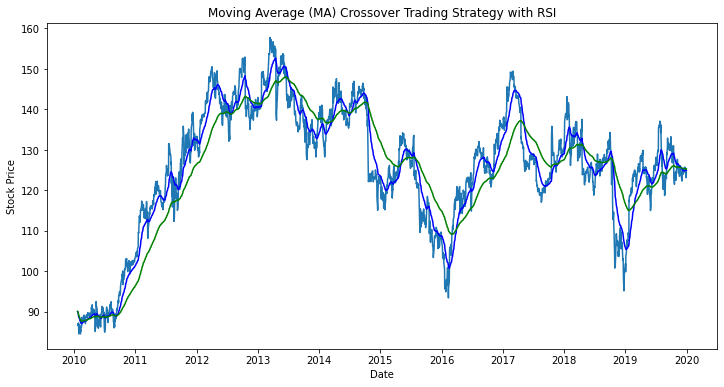

Profit of the trading strategy: 3.53%
Actual capital: $103.53


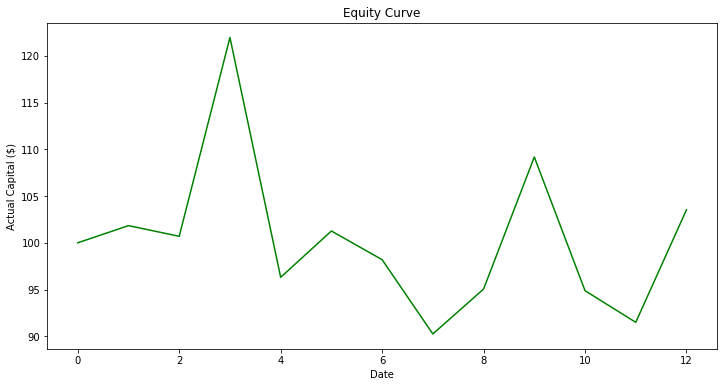

In [23]:
if __name__ == '__main__':
    
    start_date = datetime.datetime(2010, 1, 1)
    end_date   = datetime.datetime(2020, 1, 1)
    
    model = MovingAverageRSIStrategy(100, 'IBM', start_date, end_date, 40, 150)
    model.download_data()
    model.construct_signals()
    model.plot_signals()
    model.simulate()
    model.plot_equity()